The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text

In [95]:
import pandas as pd

from azureml.core import Experiment, Run, Workspace
import azureml.core
import numpy as np
import pandas as pd
import csv
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import os
import gensim
import nltk as nl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import utils
import matplotlib.pyplot as plt

In [96]:
data = {'Label':[1,2,3,4,5],
        'Type':["RomCom","Horror","Heist","Comedy","Sci-Fi"]}

dftype = pd.DataFrame (data, columns = ['Label','Type'])

dftype

,Label,Type
0,1,RomCom
1,2,Horror
2,3,Heist
3,4,Comedy
4,5,Sci-Fi


In [97]:
#Create a function to save on code
def getfilelistDF(location):
    allscripts = os.listdir(location)
    allscripts
    filename = ''
    dfscript = pd.DataFrame(columns = ['Label', 'Text', 'filename'])

    for script in allscripts:
        if script[-4:] == '.txt':
            filename = script
            raw_text = open(location + filename, 'r', encoding='utf-8').read()
            #raw_text = raw_text.lower()
            dfscript = dfscript.append({'Label':filename[0], 'Text':raw_text, 'filename':filename}, ignore_index=True)
    return dfscript

In [98]:
#Get training data from 2 directories
dfscript1 = getfilelistDF("./Scripts/")
dfscript2 = getfilelistDF("./FullScripts/")

#Concat and reindex
dfscript = pd.concat([dfscript1, dfscript2])
dfscript = dfscript.reset_index(drop=True)

#Get the testing data
dfscriptTesting =  getfilelistDF("./FullScripts/Test/")


In [99]:
nl.word_tokenize(dfscript.iloc[0]["Text"])

['[',
 'Whistling',
 ']',
 '[',
 'Pencil',
 'Scribbling',
 'Rapidly',
 ']',
 '[',
 'Whistling',
 'Continues',
 ']',
 '[',
 'Man',
 'Narrating',
 ']',
 'This',
 'is',
 'a',
 'story',
 'of',
 'boy',
 'meets',
 'girl',
 '.',
 'The',
 'boy',
 ',',
 'Tom',
 'Hansen',
 'of',
 'Margate',
 ',',
 'NewJersey',
 ',',
 'grew',
 'up',
 'believing',
 'that',
 'he',
 "'d",
 'never',
 'truly',
 'be',
 'happy',
 '...',
 'until',
 'the',
 'day',
 'he',
 'met',
 '``',
 'the',
 'one',
 '.',
 "''",
 'This',
 'beliefstemmed',
 'from',
 'early',
 'exposure',
 'to',
 'sad',
 'British',
 'pop',
 'music',
 '...',
 'and',
 'a',
 'total',
 'misreading',
 'of',
 'the',
 'movie',
 'The',
 'Graduate',
 '.',
 '[',
 'Dustin',
 'Hoffman',
 'On',
 'TV',
 ']',
 'Elaine',
 '!',
 'Elaine',
 '!',
 '[',
 'Narrator',
 ']',
 'The',
 'girl',
 ',',
 'Summer',
 'Finn',
 'ofShinnecock',
 "'",
 "Michigan'",
 'did',
 'not',
 'share',
 'this',
 'belief',
 '.',
 'Since',
 'the',
 'disintegration',
 'of',
 'her',
 'parents',
 "'",
 "ma

In [100]:
#import nltk
#nltk.download('abc')

In [101]:
dfscript.iloc[0]["Text"]

"[ Whistling ]\n[ Pencil Scribbling Rapidly ]\n[ Whistling Continues ]\n[ Man Narrating ]\nThis is a story of boy meets girl.\nThe boy, Tom Hansen\nof Margate, NewJersey,\ngrew up believing that\nhe'd never truly be happy...\nuntil the day he met ''the one.''\nThis beliefstemmed from early exposure\nto sad British pop music...\nand a total misreading\nof the movie The Graduate.\n[ Dustin Hoffman On TV ]\nElaine! Elaine!\n[ Narrator]\nThe girl, Summer Finn\nofShinnecock' Michigan'\ndid not share this belief.\nSince the disintegration\nof her parents' marriage'\nshe'd only loved two things.\nThe first was her long' dark hair.\nThe second was how easily\nshe could cut it off...\nand feel nothing.\nTom meets Summer onJanuary 8.\nHe knows almost immediately\nshe's who he's been searching for.\nThis is a story of boy meets girl.\nBut you should know up front'\nthis is not a love story.\nThey made a statue of us\nAnd put it on a mountaintop\nNow tourists come and stare at us\nBlow bubbles wit

In [102]:
#Remove all the stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

for index, row in dfscript.iterrows():
    dfscript.iloc[index]["Text"] = dfscript.iloc[index].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))["Text"]


In [103]:
dfscript.iloc[0]["Text"]

"[ Whistling ] [ Pencil Scribbling Rapidly ] [ Whistling Continues ] [ Man Narrating ] This story boy meets girl. The boy, Tom Hansen Margate, NewJersey, grew believing he'd never truly happy... day met ''the one.'' This beliefstemmed early exposure sad British pop music... total misreading movie The Graduate. [ Dustin Hoffman On TV ] Elaine! Elaine! [ Narrator] The girl, Summer Finn ofShinnecock' Michigan' share belief. Since disintegration parents' marriage' she'd loved two things. The first long' dark hair. The second easily could cut off... feel nothing. Tom meets Summer onJanuary 8. He knows almost immediately he's searching for. This story boy meets girl. But know front' love story. They made statue us And put mountaintop Now tourists come stare us Blow bubbles gum Take photographs offun Have fun They'll name city us And later say fault Then they'll give us talking 'Cause they've got years ofexperience [ Vocalizing ] Living den ofthieves Rummaging answers pages [ Vocalizing ] Liv

In [104]:
dfscript["filename"][50:60]

50                     5_Star Wars.txt
51                      5_superman.txt
52    1_10 Things I Hate About You.txt
53            1_500 Days of Summer.txt
54            1_As Good As It Gets.txt
55                 1_Groundhog Day.txt
56        1_Hannah and Her Sisters.txt
57                 1_High Fidelity.txt
58                 1_Jerry Maguire.txt
59           1_Lost in Translation.txt
Name: filename, dtype: object

In [105]:
dfscript.iloc[50]["filename"]

'5_Star Wars.txt'

In [106]:
word_list = gensim.utils.simple_preprocess(str(dfscript.iloc[50]["Text"]))

In [107]:
word_list[:50]

['did',
 'hear',
 'that',
 'they',
 've',
 'shut',
 'main',
 'reactor',
 'we',
 'll',
 'destroyed',
 'sure',
 'this',
 'madness',
 'we',
 're',
 'doomed',
 'there',
 'll',
 'escape',
 'princess',
 'time',
 'what',
 'that',
 'you',
 'at',
 'last',
 'where',
 'been',
 'they',
 're',
 'heading',
 'direction',
 'what',
 'going',
 'do',
 'we',
 'll',
 'sent',
 'spice',
 'mines',
 'kessel',
 'smashed',
 'knows',
 'what',
 'wait',
 'minute',
 'where',
 'going',
 'the']

In [108]:
#Create the word model
model = gensim.models.Word2Vec(
    [word_list], 
    negative=10, 
    iter=50, 
    min_count=1, 
    size=32 #dimension of the word vector
    )

In [109]:
list(model.wv.vocab)[0:10]

['did', 'hear', 'that', 'they', 've', 'shut', 'main', 'reactor', 'we', 'll']

In [110]:
model.wv.most_similar('star')

[('death', 0.9923211932182312),
 ('moon', 0.9907954931259155),
 ('chosen', 0.9907030463218689),
 ('planet', 0.9901831746101379),
 ('test', 0.9894660711288452),
 ('estimated', 0.9892829060554504),
 ('towers', 0.9889075756072998),
 ('chances', 0.9888393878936768),
 ('maximum', 0.9879799485206604),
 ('velocity', 0.9878189563751221)]

In [111]:
model.wv.most_similar('gold')

[('starting', 0.9947665333747864),
 ('copy', 0.9889364242553711),
 ('five', 0.9870370626449585),
 ('leader', 0.985491156578064),
 ('three', 0.9791070818901062),
 ('six', 0.9744037985801697),
 ('interference', 0.9722156524658203),
 ('standing', 0.9718952178955078),
 ('low', 0.9699084758758545),
 ('two', 0.9690251350402832)]

In [112]:
model.wv.most_similar('ben')

[('hope', 0.993330717086792),
 ('help', 0.9829177260398865),
 ('kenobi', 0.9807894229888916),
 ('wan', 0.9807401299476624),
 ('obi', 0.9782953262329102),
 ('old', 0.9752696752548218),
 ('bythe', 0.9600010514259338),
 ('property', 0.9579517841339111),
 ('related', 0.9577471613883972),
 ('meet', 0.9509899020195007)]

In [113]:
model.wv.most_similar(positive=['jedi'])

[('extinct', 0.996863603591919),
 ('murdered', 0.9964351654052734),
 ('knight', 0.9952738285064697),
 ('betrayed', 0.995140790939331),
 ('ways', 0.9950315952301025),
 ('best', 0.9947767853736877),
 ('dark', 0.9945518970489502),
 ('flowing', 0.9945484399795532),
 ('seduced', 0.9939839243888855),
 ('young', 0.9933691024780273)]

In [114]:
model.wv.most_similar(positive=['weapon'], negative=["blaster"])

[('question', 0.5145949721336365),
 ('kenobi', 0.46404486894607544),
 ('obi', 0.46212589740753174),
 ('wan', 0.45085394382476807),
 ('he', 0.4389617145061493),
 ('old', 0.41903889179229736),
 ('ben', 0.40809446573257446),
 ('related', 0.3786148428916931),
 ('hope', 0.37574249505996704),
 ('help', 0.362501859664917)]

In [115]:
model.predict_output_word(["only", "hope"])

[('ben', 0.0025779626),
 ('hope', 0.002301716),
 ('help', 0.0022262016),
 ('kenobi', 0.002205447),
 ('old', 0.0020956867),
 ('obi', 0.0020320641),
 ('wan', 0.0019547734),
 ('man', 0.0018664309),
 ('says', 0.0015219479),
 ('might', 0.0014543512)]

In [116]:
model.predict_output_word(["twelve", "parsecs"])

[('coming', 0.00096004724),
 ('alderaan', 0.0009526201),
 ('hold', 0.0009483082),
 ('force', 0.000942684),
 ('enough', 0.00092907535),
 ('them', 0.00092137494),
 ('are', 0.0009200611),
 ('run', 0.0009119432),
 ('range', 0.00090980745),
 ('make', 0.0009042914)]

In [117]:
list(model.wv.vocab)[0:25]

['did',
 'hear',
 'that',
 'they',
 've',
 'shut',
 'main',
 'reactor',
 'we',
 'll',
 'destroyed',
 'sure',
 'this',
 'madness',
 're',
 'doomed',
 'there',
 'escape',
 'princess',
 'time',
 'what',
 'you',
 'at',
 'last',
 'where']

CPU times: user 18 µs, sys: 1e+03 ns, total: 19 µs
Wall time: 6.91 µs


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


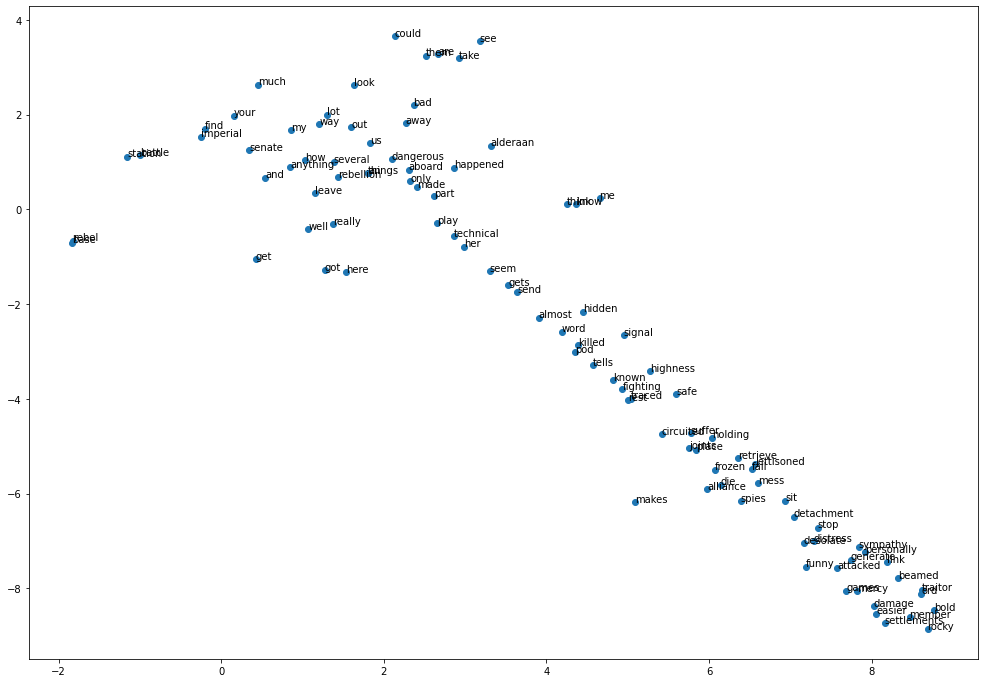

In [118]:
#Visulaize the word clusters
%time

from sklearn.manifold import TSNE
vocab = list(model.wv.vocab)[100:200]
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(17,12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

In [175]:
vocab = list(model.wv.vocab)[100:200]
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

df.loc[(df['x'] > -1) & (df['x'] < 0) & (df['y'] > 0) & (df['y'] < 3)]

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,x,y
things,-0.531082,1.891240
only,-0.817983,2.388437
senate,-0.026442,0.501645
several,-0.293063,1.500574
and,-0.504014,0.678207
dangerous,-0.302006,2.205212
rebellion,-0.700812,1.555647
anything,-0.300637,0.971518
leave,-0.940389,1.139123
aboard,-0.607794,2.376332


In [119]:
dfscriptwordlist = dfscript

for index, row in dfscriptwordlist.iterrows():
    text = gensim.utils.simple_preprocess(str(row["Text"]))
    dfscriptwordlist.iloc[index]["Text"] = text

In [120]:
dfscriptwordlist.head()

,Label,Text,filename
0,1,"[whistling, pencil, scribbling, rapidly, whist...",1_500 days of summer.txt
1,1,"[bridget, it, began, new, year, day, thirty, s...",1_Bridget Jones Diary.txt
2,1,"[oh, come, save, room, love, save, room, momen...",1_Crazy Stupid Love.txt
3,1,"[hi, everybody, this, cousin, brucie, whoa, ou...",1_dirty dancing.txt
4,1,"[man, narrating, whenever, get, gloomy, state,...",1_love actually.txt


In [121]:
X_train, X_test, y_train, y_test = train_test_split(dfscriptwordlist[["Text", "filename"]], dfscriptwordlist["Label"], test_size=0.1)

In [122]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [123]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [124]:
tagged_data = [TaggedDocument(words=d, tags=y_train.iloc[i]) for i, d in enumerate(X_train["Text"])]
tagged_data_test = [TaggedDocument(words=d, tags=y_train.iloc[i]) for i, d in enumerate(X_test["Text"])]


In [125]:
pd.DataFrame(tagged_data).head(2)

,words,tags
0,"[ext, the, port, of, genoa, italy, night, fork...",3
1,"[extreme, closeups, of, flickering, instrument...",5


In [126]:
#Building a Vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(tagged_data)])

100%|██████████| 125/125 [00:00<00:00, 1081006.19it/s]


In [127]:
%%time
#Train epochs
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(tagged_data)]), total_examples=len(tagged_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 125/125 [00:00<00:00, 991092.63it/s]


CPU times: user 11.8 s, sys: 55.1 ms, total: 11.9 s
Wall time: 4.07 s


In [128]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    label, features = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return label, features

In [129]:
%%time
from sklearn.neural_network import MLPClassifier
y_trainV, X_trainV = vec_for_learning(model_dbow, tagged_data)
y_testV, X_testV = vec_for_learning(model_dbow, tagged_data_test)
modelM = MLPClassifier()
modelM.fit(X_trainV, y_trainV)
y_pred_test = modelM.predict(X_testV)
y_pred = modelM.predict(X_trainV)


CPU times: user 36.7 s, sys: 758 ms, total: 37.5 s
Wall time: 36.3 s


In [130]:
pd.DataFrame(tagged_data)

,words,tags
0,"[ext, the, port, of, genoa, italy, night, fork...",3
1,"[extreme, closeups, of, flickering, instrument...",5
2,"[silent, endless, the, stars, shine, like, lov...",5
3,"[have, got, biscuits, there, here, cornbread, ...",5
4,"[ext, the, big, blue, sky, day, virgin, air, b...",4
...,...,...
120,"[ext, providence, rhode, island, winter, morni...",4
121,"[somebody, asked, me, phil, could, anywhere, w...",4
122,"[voice, in, crime, rate, united, states, rises...",5
123,"[ext, sky, night, the, moon, stars, visible, c...",5


In [131]:
pd.DataFrame(X_trainV[0:5])

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.348986,0.454089,-1.311366,-1.707456,0.001209,0.689539,-0.305843,-0.799474,-0.716299,-0.201136,...,0.429335,0.195615,0.313675,-0.120108,-0.218512,-0.151015,-0.084718,-0.352093,0.137101,0.326004
1,0.265976,-0.114006,-0.313451,-0.177079,1.234016,1.860476,-0.627657,-0.173069,0.326133,0.013471,...,-0.159211,-0.611696,0.274309,-0.889194,0.327341,-0.278018,0.169737,-0.241795,-0.003389,0.363770
2,0.086260,-0.214166,1.507530,-0.366539,0.505826,1.215485,-0.610678,0.406546,-0.509505,0.102053,...,-0.453548,-0.478016,-0.110238,-0.049613,0.517273,-0.250819,-0.091926,0.564438,0.463637,-0.064906
3,0.295040,1.537138,-0.116992,-0.576699,0.070908,-0.506373,-0.093502,0.883875,0.482519,0.038835,...,-0.116014,-0.580589,-0.644595,-0.122419,0.078128,-0.341713,0.162384,0.679375,-0.001439,-0.076932
4,1.440488,0.585060,0.387677,-2.307818,-0.086628,-0.650847,-0.928689,-0.286498,0.560509,0.661037,...,0.137789,0.137502,-0.191523,-0.109801,-0.231787,-0.045546,-0.157908,-0.360892,-0.396749,-0.212618


accuracy training data = 1.0




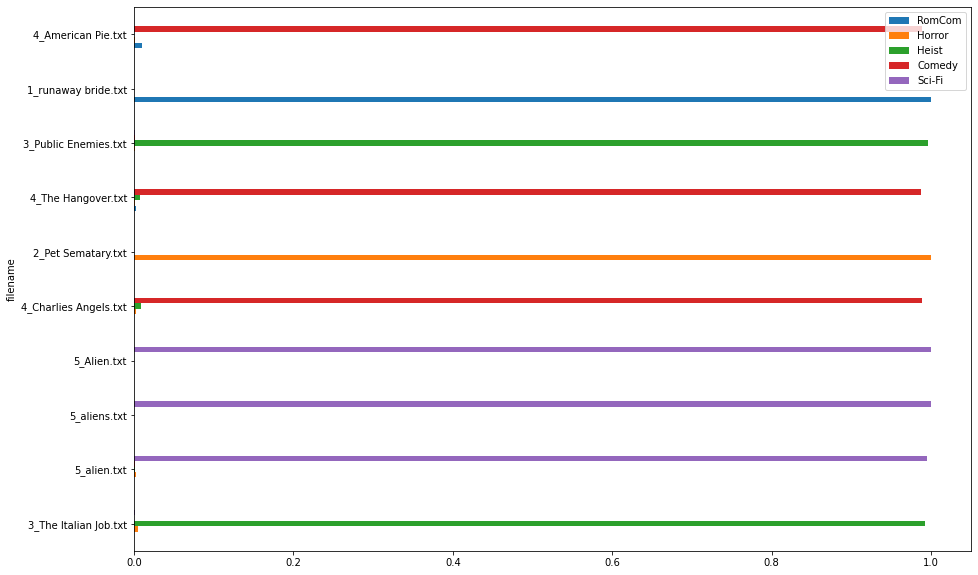

In [132]:
print('accuracy training data = ' + str(np.mean(y_pred == y_train)))
print('\r')
print('\r')
dfres = pd.DataFrame(modelM.predict_proba(X_trainV)).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['actual'] = y_trainV
dfres['predicted'] = y_pred
dfres['filename'] = X_train["filename"]
dfres

dfres.head(10).plot.barh(x='filename',figsize=(15,10), sort_columns=True)
plt.show()


accuracy testing data = 0.5714285714285714




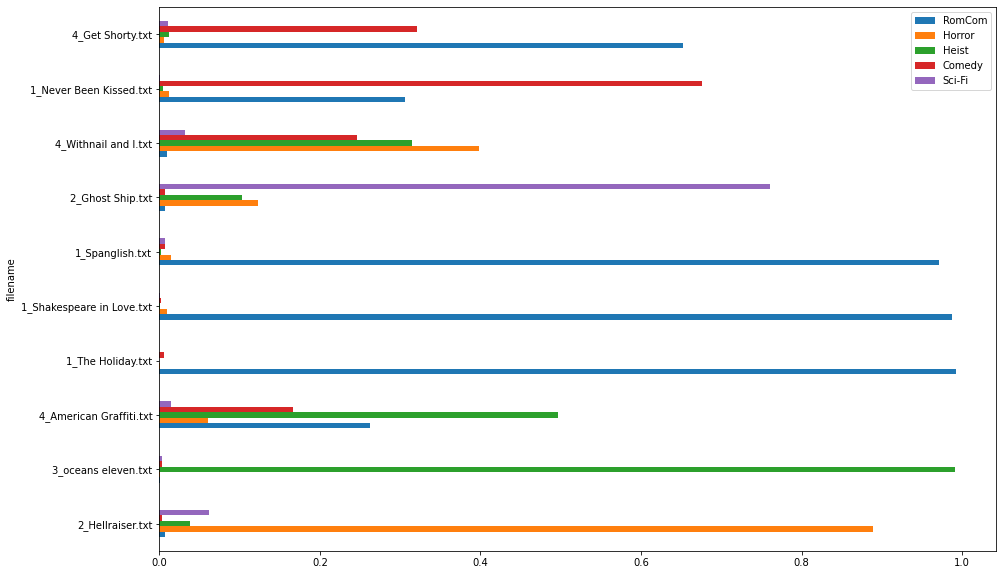

In [133]:
print('accuracy testing data = ' + str(np.mean(y_pred_test == y_test)))
print('\r')
print('\r')
dfres = pd.DataFrame(modelM.predict_proba(X_testV)).rename(columns = {0:'RomCom', 1:'Horror', 2:"Heist" , 3: "Comedy", 4: "Sci-Fi"})
dfres['actual'] = y_testV
dfres['predicted'] = y_pred_test
dfres['filename'] = X_test["filename"]
dfres

import matplotlib.pyplot as plt
dfres.head(10).plot.barh(x='filename',figsize=(15,10), sort_columns=True)
plt.show()
